# Example for the teleconnections

In [3]:
import yaml
import xarray as xr
import matplotlib.pyplot as plt

diagname  = 'teleconnections'
machine   = 'wilma'
telecname = 'NAO'

with open(f'../../config/config_{machine}.yml', 'r', encoding='utf-8') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

with open(f'{diagname}.yml', 'r', encoding='utf-8') as file:
    namelist = yaml.load(file, Loader=yaml.FullLoader)

infile = config[diagname]['input']

field = xr.open_mfdataset(infile)['msl']

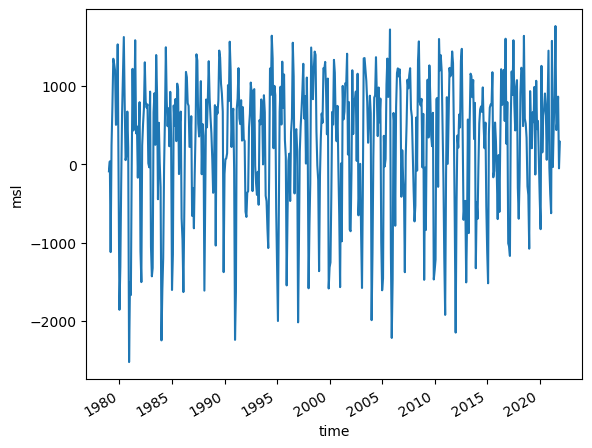

In [4]:
prs1 = field.sel(lon=namelist[telecname]['lon1'],lat=namelist['NAO']['lat1'])
prs2 = field.sel(lon=namelist[telecname]['lon2'],lat=namelist['NAO']['lat2'])

indx = prs1-prs2
indx.plot()

## DJF selection

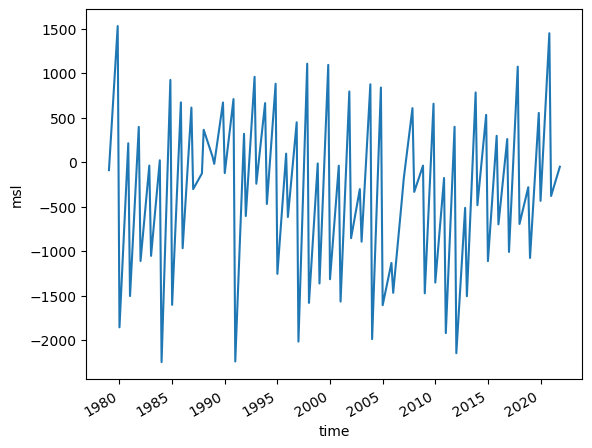

In [37]:
prs1_winter = prs1.sel(time=prs1.time.dt.month.isin([0, 1, 11]))
prs2_winter = prs2.sel(time=prs2.time.dt.month.isin([0, 1, 11]))
indx_winter = prs1_winter-prs2_winter
indx_winter.plot()

## Seasonal (3-month) average

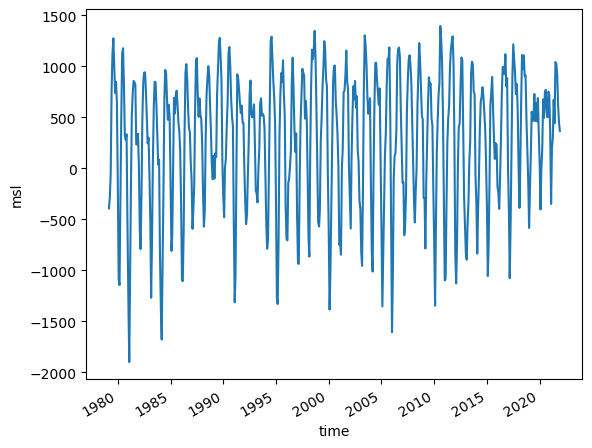

In [49]:
prs1_ma = prs1.rolling(time=3).mean()
prs2_ma = prs2.rolling(time=3).mean()

indx_ma = prs1_ma-prs2_ma
indx_ma.plot()

## Index evaluation

In [68]:
mean = indx_ma.mean()
std  = indx_ma.std()

indx_std = indx_ma/mean

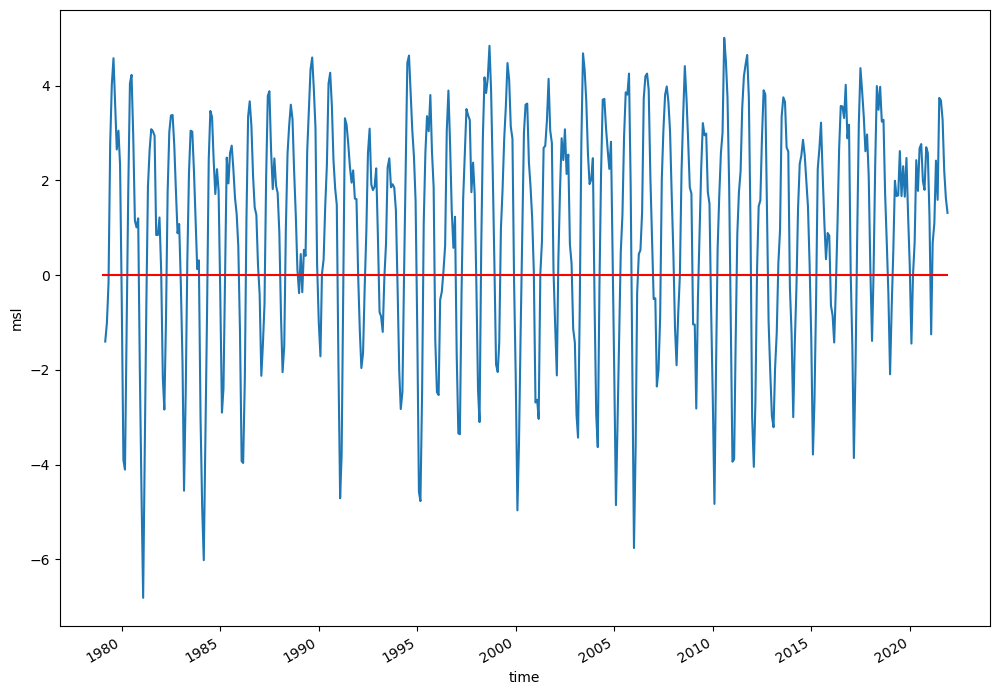

In [88]:
fig, ax = plt.subplots(figsize=(12, 8))

#ax.set_xlabel('time')
#ax.set_ylabel('msl')
#ax.hlines(y=0,xmin=0,xmax=1000,c='red')
indx_std.plot(ax=ax)
ax.hlines(y=0,xmin=min(indx_std['time']),xmax=max(indx_std['time']),color='red')

In [86]:
indx_std['time']

<xarray.DataArray 'time' (time: 516)>
array(['1979-01-01T00:00:00.000000000', '1979-02-01T00:00:00.000000000',
       '1979-03-01T00:00:00.000000000', ..., '2021-10-01T00:00:00.000000000',
       '2021-11-01T00:00:00.000000000', '2021-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Attributes:
    standard_name:  time
    axis:           T